# Read our dataset with Detectron2 library

### After saving the available data in a dataframe and the images in the correct folders, it's possible to load the dataset as expected by the library.

### Import required libraries.

In [1]:
import os
import cv2
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Function to generate de object directories.

This code will be highly inspired by the library tutorial.

In [2]:
def get_tumors_dicts(df, folder, is_train_folder=True):
    
    # Select only one set of images.
    df = df[df['Train_Set'] == is_train_folder]

    # All dictionaries will be stored here.
    objects_dicts = []

    for idx, row in df.iterrows():

        # Object dictionary
        obj_dict = {}

        img_name = os.path.splitext(row['MatLab_File_Name'])[0] + '.png'
        img_path = os.path.join(folder, img_name)

        height, width = row['Image_Array'].shape

        poly = row['Tumor_Border'][0]
        px = poly[::2]
        py = poly[1::2]
        poly += 0.5

        obj_border = {
            "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": [poly],
            "category_id": 0,
        }
        
        obj_dict["file_name"] = img_path
        obj_dict["image_id"] = idx
        obj_dict["height"] = height
        obj_dict["width"] = width
        obj_dict["annotations"] = [obj_border]

        objects_dicts.append(obj_dict)
    
    return objects_dicts

### Read pickle and numpy files, construct dataframe and load it in the function.

In [3]:
df = pd.read_pickle('dataframe_brain_tumor.pickle')
df.head()

,Image_Array,Mask_Array,Tumor_Border,Patient_ID,Cancer_Type,MatLab_File_Name
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[143.97731474260132, 267.0883519862749, 159.9...",MR034694,2,2628.mat
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[139.14982578397212, 346.98257839721254, 137....",MR049453,2,1916.mat
2,"[[0, 0, 0, 0, 0, 0, 0, 3, 7, 11, 12, 10, 11, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[329.3275833082408, 188.86902810845277, 334.7...",107429,3,1187.mat
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[253.11311346501296, 289.2721296743005, 254.3...",113554,1,161.mat
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 21, 24, 25, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[274.7317073170732, 272.9477351916376, 289.89...",MR049104,2,2855.mat


In [4]:
train_set = np.load("train_and_valid_separation.npy")
train_set.shape, np.sum(train_set)

((3064,), 2766)

In [5]:
df['Train_Set'] = train_set
df.head()

,Image_Array,Mask_Array,Tumor_Border,Patient_ID,Cancer_Type,MatLab_File_Name,Train_Set
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[143.97731474260132, 267.0883519862749, 159.9...",MR034694,2,2628.mat,True
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[139.14982578397212, 346.98257839721254, 137....",MR049453,2,1916.mat,True
2,"[[0, 0, 0, 0, 0, 0, 0, 3, 7, 11, 12, 10, 11, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[329.3275833082408, 188.86902810845277, 334.7...",107429,3,1187.mat,True
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[253.11311346501296, 289.2721296743005, 254.3...",113554,1,161.mat,True
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 21, 24, 25, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[274.7317073170732, 272.9477351916376, 289.89...",MR049104,2,2855.mat,True


## Register dataset and see images.

In [6]:
train_folder = Path("Cheng_Dataset/train")
val_folder = Path("Cheng_Dataset/val")

DatasetCatalog.register("brain_tumor_train", lambda: get_tumors_dicts(df, train_folder, is_train_folder=True))
DatasetCatalog.register("brain_tumor_val", lambda: get_tumors_dicts(df, val_folder, is_train_folder=False))
MetadataCatalog.get("brain_tumor_train").set(thing_classes=["tumor"])
MetadataCatalog.get("brain_tumor_val").set(thing_classes=["tumor"])
brain_tumor_metadata = MetadataCatalog.get("brain_tumor_train")

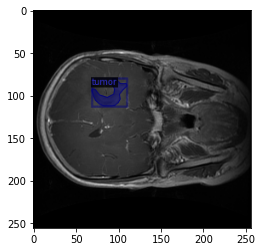

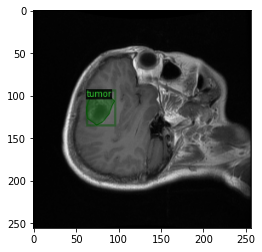

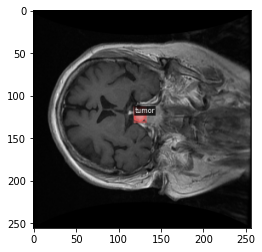

In [7]:
objects_dicts = get_tumors_dicts(df, train_folder)

for d in random.sample(objects_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=brain_tumor_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

## Evaluate obtained segmentation borders

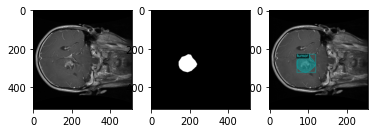

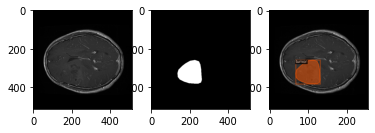

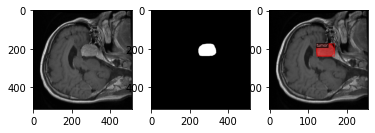

In [9]:
train_df = df[df['Train_Set'] == True]

for idx, d in enumerate(objects_dicts[:3]):

    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=brain_tumor_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    processed_img = out.get_image()[:, :, ::-1]

    original_img = train_df.Image_Array[idx]
    mask = train_df.Mask_Array[idx]

    fig = plt.figure()
    sub_figs = list(map(lambda i: fig.add_subplot(1,3,i), range(1, 4)))
    plots = list(map(lambda image, sf: sf.imshow(image, cmap='gray'), [original_img, mask, processed_img], sub_figs))

    plt.show()

The segmentation looks **quite satisfactory.**